In [8]:
#seed 2 works for 8, 12 not 10
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
import diffrax as dfx
import growth_rate_08f
import growth_rate_10f
import growth_rate_12f

system_08 = growth_rate_08f.BigField(num_neurons=40,seed=7,num_obs=9)
system_10 = growth_rate_10f.BigField(num_neurons=40,seed=4,num_obs=9)
system_12 = growth_rate_12f.BigField(num_neurons=40,seed=2,num_obs=9)
learned_system_08 = eqx.tree_deserialise_leaves('./growth_rate_08/epoch_2235seed_2val8.17067871939151.eqx' , system_08)
learned_system_10 = eqx.tree_deserialise_leaves('./growth_rate_10/epoch_1814seed_2val10.393508191545337.eqx' , system_10)
learned_system_12 = eqx.tree_deserialise_leaves('./growth_rate_12/epoch_1240seed_2val13.199771825693924.eqx' , system_12)

self.steepness:  -7.0
self.steepness:  -7.0
self.steepness:  -7.0


In [9]:
def sample_traj(system):
    t0 = 0.0
    t1 = 40.0
    dt = 0.04
    tprev = t0
    tnext = t0 + dt


    solver = dfx.Tsit5()
    term = dfx.ODETerm(system.term)
    (x_init, s_init, e_init) = system.reset()
    obs = jnp.array([jnp.sin(x_init[0][0]), jnp.cos(x_init[0][0]), x_init[0][1],
                     jnp.sin(x_init[0][2]), jnp.cos(x_init[0][2]), x_init[0][3],
                     s_init[0][5], s_init[0][7], e_init[0][0]])
    z_init = system.produce_z(obs)
    y = (x_init[0], z_init, s_init[0], e_init[0])
    args = None
    state = solver.init(term, tprev, tnext, y, args)
    cumulutive_resources = []
    ss=[]
    while tprev < t1:
        y, _, _, state, _ = solver.step(term, tprev, tnext, y, args, state, made_jump=False)
        tprev = tnext
        tnext = min(t1, tprev+dt)
        cumulutive_resources.append(y[3])
        ss.append(y[2])
    return cumulutive_resources,ss

In [10]:
cr_08,ss_08 = sample_traj(learned_system_08)
cr_10,ss_10 = sample_traj(learned_system_10)
cr_12,ss_12 = sample_traj(learned_system_12)


In [12]:
def patch_arrival(ss):
    patch_arrival_times = []
    ss = jnp.array(ss)
    ss0 = ss[:,0]
    ss1 = ss[:,1]
    flag0 = False
    flag1 = False
    for i in range(len(ss0)-1):
        if ss0[i+1] < ss0[i] and flag0 == False:
            patch_arrival_times.append(i)
            flag0 = True
        elif ss0[i+1] > ss0[i]:
            flag0 = False
        if ss1[i+1] < ss1[i] and flag1 == False:
            patch_arrival_times.append(i)
            flag1 = True
        elif ss1[i+1] > ss1[i]:
            flag1 = False
    #print(patch_arrival_times)
    return patch_arrival_times

def patch_departure(ss0, ss1):
    patch_departure_times = []
    flag0 = True
    flag1 = True
    for i in range(len(ss0)-1):
        if ss0[i+1] > ss0[i] and flag0 == False:
            patch_departure_times.append(i)
            flag0 = True
        elif ss0[i+1] < ss0[i]:
            flag0 = False
        if ss1[i+1] > ss1[i] and flag1 == False:
            patch_departure_times.append(i)
            flag1 = True
        elif ss1[i+1] < ss1[i]:
            flag1 = False
    #print(patch_departure_times)
    return patch_departure_times

In [13]:
cr_08 = jnp.array(cr_08)
cr_10 = jnp.array(cr_10)
cr_12 = jnp.array(cr_12)
ss_08 = jnp.array(ss_08)
ss_10 = jnp.array(ss_10)
ss_12 = jnp.array(ss_12)
ss_08_1 = ss_08[:,0]
ss_08_2 = ss_08[:,1]
ss_10_1 = ss_10[:,0]
ss_10_2 = ss_10[:,1]
ss_12_1 = ss_12[:,0]
ss_12_2 = ss_12[:,1]

patch_arrival_08 = patch_arrival(ss_08)
patch_arrival_10 = patch_arrival(ss_10)
patch_arrival_12 = patch_arrival(ss_12)
patch_departure_08 = patch_departure(ss_08_1, ss_08_2)
patch_departure_10 = patch_departure(ss_10_1, ss_10_2)
patch_departure_12 = patch_departure(ss_12_1, ss_12_2)

print(patch_arrival_08)
print(patch_arrival_10)
print(patch_arrival_12)
print(patch_departure_08)
print(patch_departure_10)
print(patch_departure_12)

[166, 314, 538, 911]
[29, 166, 347, 572, 791, 996]
[252, 386, 494, 691, 872]
[252, 461, 824]
[52, 281, 486, 697, 911]
[278, 434, 617, 777, 934]


In [14]:
import seaborn as sns

sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)

average patch duration 0.08 =  173.0
average patch duration 0.1 =  92.33333333333333
average patch duration 0.12 =  65.66666666666667


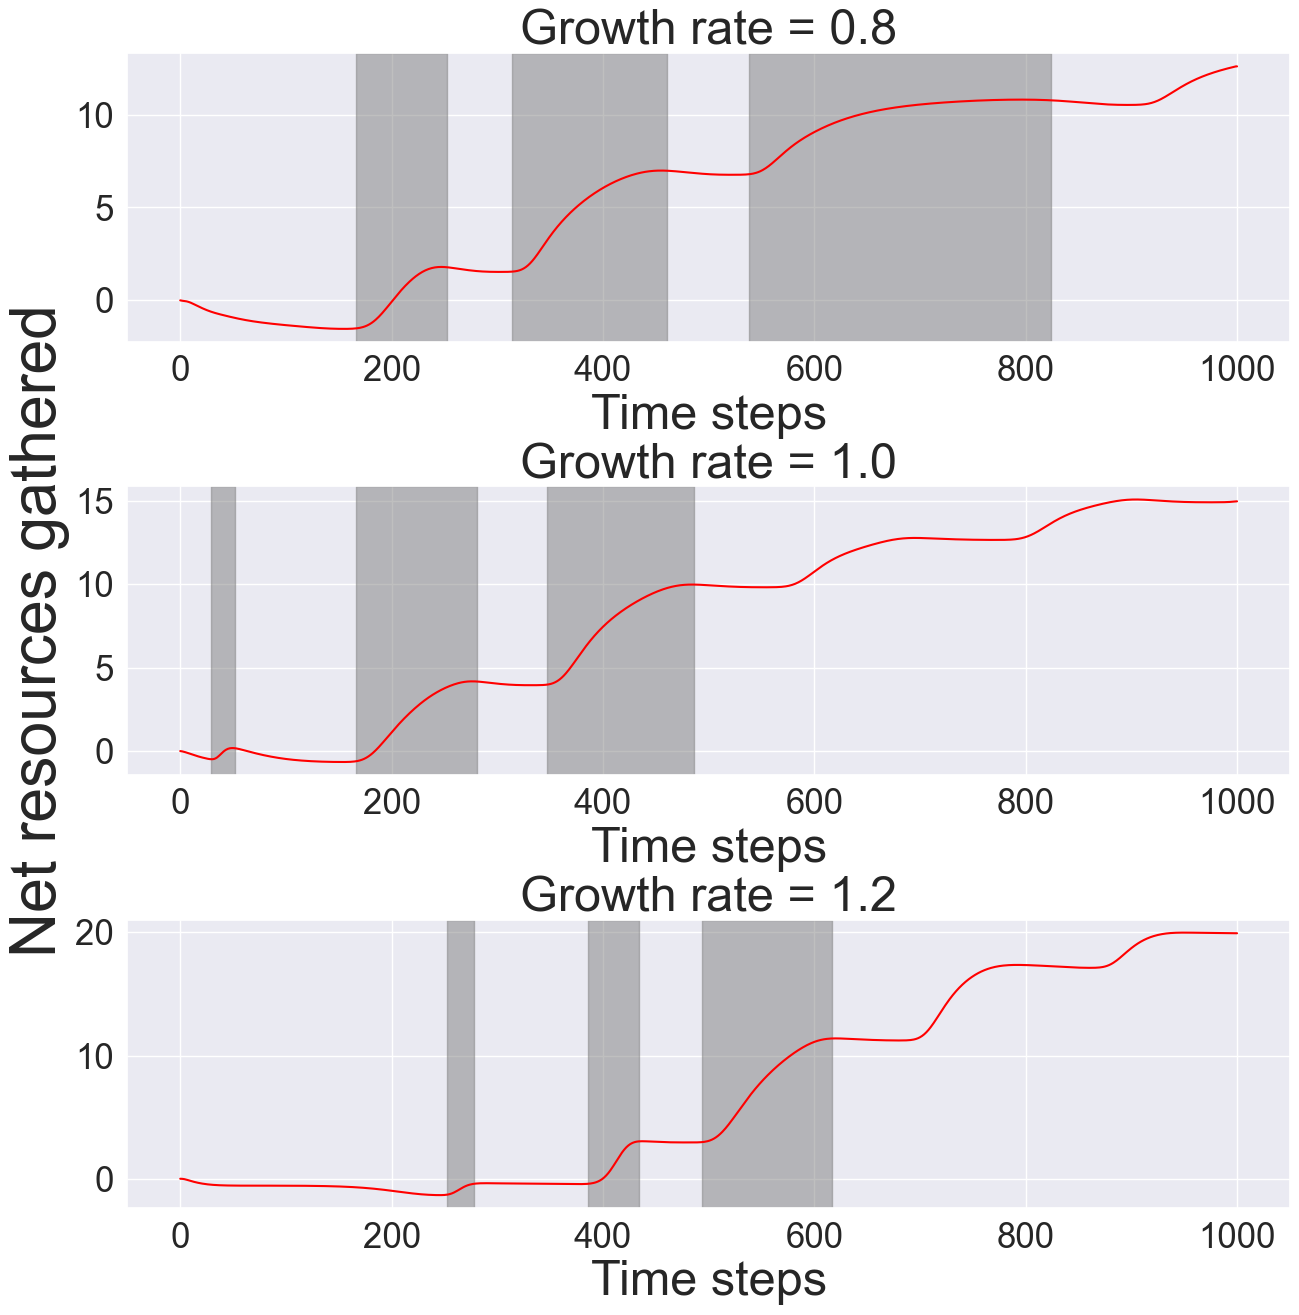

In [18]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)

ax[0].plot(cr_08, color='red')
ax[0].set_xlabel('Time steps', fontsize=35)
ax[0].set_title('Growth rate = 0.8', fontsize=35)
ax[0].axvspan(patch_arrival_08[0], patch_departure_08[0], color='grey', alpha=0.5)
ax[0].axvspan(patch_arrival_08[1], patch_departure_08[1], color='grey', alpha=0.5)
ax[0].axvspan(patch_arrival_08[2], patch_departure_08[2], color='grey', alpha=0.5)

print("average patch duration 0.08 = ", (((patch_departure_08[1]-patch_arrival_08[1])+ (patch_departure_08[0]-patch_arrival_08[0]) 
                                         +(patch_departure_08[2]-patch_arrival_08[2]))/3))
ax[0].tick_params(axis='both', which='major', labelsize=25)

ax[1].plot(cr_10, color='red')
ax[1].set_xlabel('Time steps', fontsize=35)
ax[1].set_ylabel('Net resources gathered', fontsize=45)
ax[1].set_title('Growth rate = 1.0', fontsize=35)
ax[1].axvspan(patch_arrival_10[0], patch_departure_10[0], color='grey', alpha=0.5)
ax[1].axvspan(patch_arrival_10[1], patch_departure_10[1], color='grey', alpha=0.5)
ax[1].axvspan(patch_arrival_10[2], patch_departure_10[2], color='grey', alpha=0.5)

ax[1].tick_params(axis='both', which='major', labelsize=25)
print("average patch duration 0.1 = ", (((patch_departure_10[1]-patch_arrival_10[1])+ (patch_departure_10[0]-patch_arrival_10[0]) 
                                         +(patch_departure_10[2]-patch_arrival_10[2]))/3))


ax[2].plot(cr_12, color='red')
ax[2].set_xlabel('Time steps', fontsize=35)
ax[2].set_title('Growth rate = 1.2', fontsize=35)
ax[2].axvspan(patch_arrival_12[0], patch_departure_12[0], color='grey', alpha=0.5)
ax[2].axvspan(patch_arrival_12[1], patch_departure_12[1], color='grey', alpha=0.5)
ax[2].axvspan(patch_arrival_12[2], patch_departure_12[2], color='grey', alpha=0.5)

ax[2].tick_params(axis='both', which='major', labelsize=25)
print("average patch duration 0.12 = ", (((patch_departure_12[1]-patch_arrival_12[1])+ (patch_departure_12[0]-patch_arrival_12[0]) 
                                         +(patch_departure_12[2]-patch_arrival_12[2]))/3))
plt.savefig('growth_rate_net_res_time_analysis.svg', format='svg', bbox_inches='tight')
plt.show()
